# Imports

In [1]:
!pip install pycocotools
!pip install -U ffmpeg
!pip install torchmetrics

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=30cb074258513d831c834f9afb1e8aef3bf4d3b1c98a260adc44a709fb5c9036
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.3 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Mon Dec 18 09:15:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualisasi data
import os
import xml.etree.ElementTree as ET # proses data XML
import cv2 # OpenCV untuk pengolahan gambar dan video
from PIL import Image # manipulasi gambar
import seaborn as sns # visualisasi data statistik
import copy # salin object
import torch
from torch.utils.data import Dataset,DataLoader,Subset # pengolahan data dari PyTorch
import torch.optim as optim # kelola optimasi model
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils # SSD (Single Shot Multibox Detector) di torchvision
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights # model SSD300 dengan arsitektur VGG16
import torchvision.transforms.functional as tf # fungsi-fungsi transformasi dari torchvision untuk memproses data gambar
import albumentations as A # augmentasi data gambar
import pycocotools # manipulsi dataset COCO
import torchmetrics # metrik-metrik untuk evaluasi model PyTorch
from torchmetrics.detection import MeanAveragePrecision # metrik Mean Average Precision (mAP) untuk evaluasi deteksi objek

# Import dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ekstrak
import zipfile
import shutil

local_zip = '/content/drive/MyDrive/Dataset/potholes4.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()
base_dir = '/content/potholes'

# Konfigurasi

In [6]:
# path directory
img_dir = "/content/images"
annot_dir = "/content/annotations"

classes = ["background","pothole"]

num_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu" # deteksi GPU
batch_size = 8
epochs = 40
learning_rate = 0.00001

model_weights_file = "model.pth" # menyimpan bobot model

threshold = 0.25 # untuk prediksi
iou_threshold = 0.75 # untuk bounding box

# Praproses

In [7]:
def parse_xml(annot_path):
    # membaca file XML
    tree = ET.parse(annot_path)
    root = tree.getroot()

    # mendapatkan lebar gambar dari XML
    width = int(root.find("size").find("width").text)
    # mendapatkan tinggi gamabr dari XML
    height = int(root.find("size").find("height").text)
    # list untuk menyimpan bounding box
    boxes = []

    # iterasii untuk mendapatkan koordinat dari bounding box
    for obj in root.findall("object"):
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        boxes.append([xmin,ymin,xmax,ymax])

    return boxes,height,width

In [8]:
ignore_img = []
for annot_name in os.listdir(annot_dir):
    # ubah nama file xml sesuai nama file gambarnya
    img_name = annot_name[:-4]+".jpg"
    annot_path = os.path.join(annot_dir, annot_name)
    boxes,height,width = parse_xml(annot_path)

    # periksa bounding box yang tidak valid
    for box in boxes:
        xmin, ymin, xmax, ymax = box

        # periksa koordinat bounding box
        if xmin < 0 or xmax > width or xmin >= xmax or ymin < 0 or ymax > height or ymin >= ymax:
            print("Invalid bounding box coordinates in:", annot_name)
            print(f"Box Coordinates: xmin={xmin}, ymin={ymin}, xmax={xmax}, ymax={ymax}")
            print(f"Image Dimensions: height={height}, width={width}")
            print("*" * 50)
            ignore_img.append(img_name)

# tampilkan daftar file gambar yang akan diabaikan
print("Images to be ignored:", ignore_img)

Invalid bounding box coordinates in: 24_jpg.rf.cbaa98aeae8fb3d2dd13389f7014124b.xml
Box Coordinates: xmin=1, ymin=29, xmax=636, ymax=641
Image Dimensions: height=640, width=640
**************************************************
Invalid bounding box coordinates in: 0000989_jpg.rf.d8edc700b6c7b79a5e1386b91ab4907e.xml
Box Coordinates: xmin=248, ymin=605, xmax=330, ymax=641
Image Dimensions: height=640, width=640
**************************************************
Invalid bounding box coordinates in: img-636_jpg.rf.c5e41aac81677a748f1aa78fae224ad6.xml
Box Coordinates: xmin=431, ymin=480, xmax=641, ymax=600
Image Dimensions: height=640, width=640
**************************************************
Invalid bounding box coordinates in: 0000989_jpg.rf.d95fa45940b32e413aebec1c2b861b9e.xml
Box Coordinates: xmin=248, ymin=605, xmax=330, ymax=641
Image Dimensions: height=640, width=640
**************************************************
Invalid bounding box coordinates in: 000846_r_jpg.rf.15f08648396

In [9]:
print(len(ignore_img))

407


# Data Augmentation

In [10]:
train_transform = A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit = 15,value = 0,
                                              border_mode = cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p = 1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height = 480,width = 480)],
                          bbox_params = A.BboxParams(format = "pascal_voc",min_visibility = 0.15,
                                                   label_fields = ["labels"]))

val_transform = A.Compose([A.Resize(height = 480,width = 480)],
                        bbox_params = A.BboxParams(format = "pascal_voc",min_visibility = 0.15,
                                                 label_fields = ["labels"]))

test_transform = A.Compose([A.Resize(height = 480,width = 480)],
                        bbox_params = A.BboxParams(format = "pascal_voc",min_visibility = 0.15,
                                                 label_fields = ["labels"]))

# Custom Dataset

In [11]:
class PotholeDetection(Dataset):
    def __init__(self, img_dir, annot_dir, transform = None):
        super().__init__()
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        # membuat list gambar selain yang ada di ignore
        self.img_list = sorted([img for img in os.listdir(self.img_dir)
                              if img not in ignore_img])
        self.transform = transform

    # panjang dataset (jumlah gambar)
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # membuat path gambar
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        # read gambar
        img = cv2.imread(img_path)
        # convert BGR ke RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # membuat path anotasi
        annot_name = img_name[:-4]+".xml"
        annot_path = os.path.join(self.annot_dir, annot_name)
        boxes,height,width = parse_xml(annot_path)
        labels = [1]*len(boxes)

        # melakukan augmentasi gambar
        if self.transform is not None:
            transformed = self.transform(image = img, bboxes = boxes, labels = labels)
            # mengganti dengan yang sudah ditransformasi
            img = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]

        # atasi anomali bounding box
        if len(np.array(boxes).shape) != 2 or np.array(boxes).shape[-1] != 4:
            boxes = [[0.0,0.0,1.0,1.0]]
            labels = [0]

        img = img/255
        img = tf.to_tensor(img)
        img = img.to(dtype = torch.float32)
        target = {}
        target["boxes"] = torch.tensor(boxes,dtype = torch.float32)
        target["labels"] = torch.tensor(labels,dtype = torch.int64)
        target["id"] = torch.tensor(idx)

        return img,target

In [12]:
train_ds = PotholeDetection(img_dir, annot_dir, train_transform)
val_ds = PotholeDetection(img_dir, annot_dir, val_transform)
test_ds = PotholeDetection(img_dir, annot_dir, test_transform)

In [13]:
# cek data
sample_idx = 2
sample_img, sample_target = train_ds[sample_idx]

print("Index:", sample_target["id"].item())
print("labels:", sample_target["labels"].tolist())
print("boxes:", sample_target["boxes"].tolist())

print("Shape of image:", sample_img.shape)

Index: 2
labels: [1, 1]
boxes: [[466.8856201171875, 468.4963073730469, 480.0, 480.0], [408.3742980957031, 422.9921875, 465.5130920410156, 452.6971435546875]]
Shape of image: torch.Size([3, 480, 480])


In [14]:
# membagi dataset menjadi data train 80%, data validation 10% dan data test 10%
idxs = list(range(len(train_ds)))

# Membagi indeks untuk masing-masing subset
np.random.shuffle(idxs)
train_idx = idxs[:int(0.7 * len(train_ds))]
val_idx = idxs[int(0.7 * len(train_ds)):int(0.9 * len(train_ds))]
test_idx = idxs[int(0.9 * len(train_ds)):]

# Membuat subset menggunakan indeks yang telah dihitung
train_ds = Subset(train_ds, train_idx)
val_ds = Subset(val_ds, val_idx)
test_ds = Subset(test_ds, test_idx)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

2407
688
344


# Data Visualization

In [16]:
def show_bbox(img, target, color = (0,255,0)):
    img = np.transpose(img.cpu().numpy(),(1,2,0))
    boxes = target["boxes"].cpu().numpy().astype("int")
    labels = target["labels"].cpu().numpy()
    img = img.copy()
    for i, box in enumerate(boxes):
        idx = int(labels[i])
        text = classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y = box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    return img

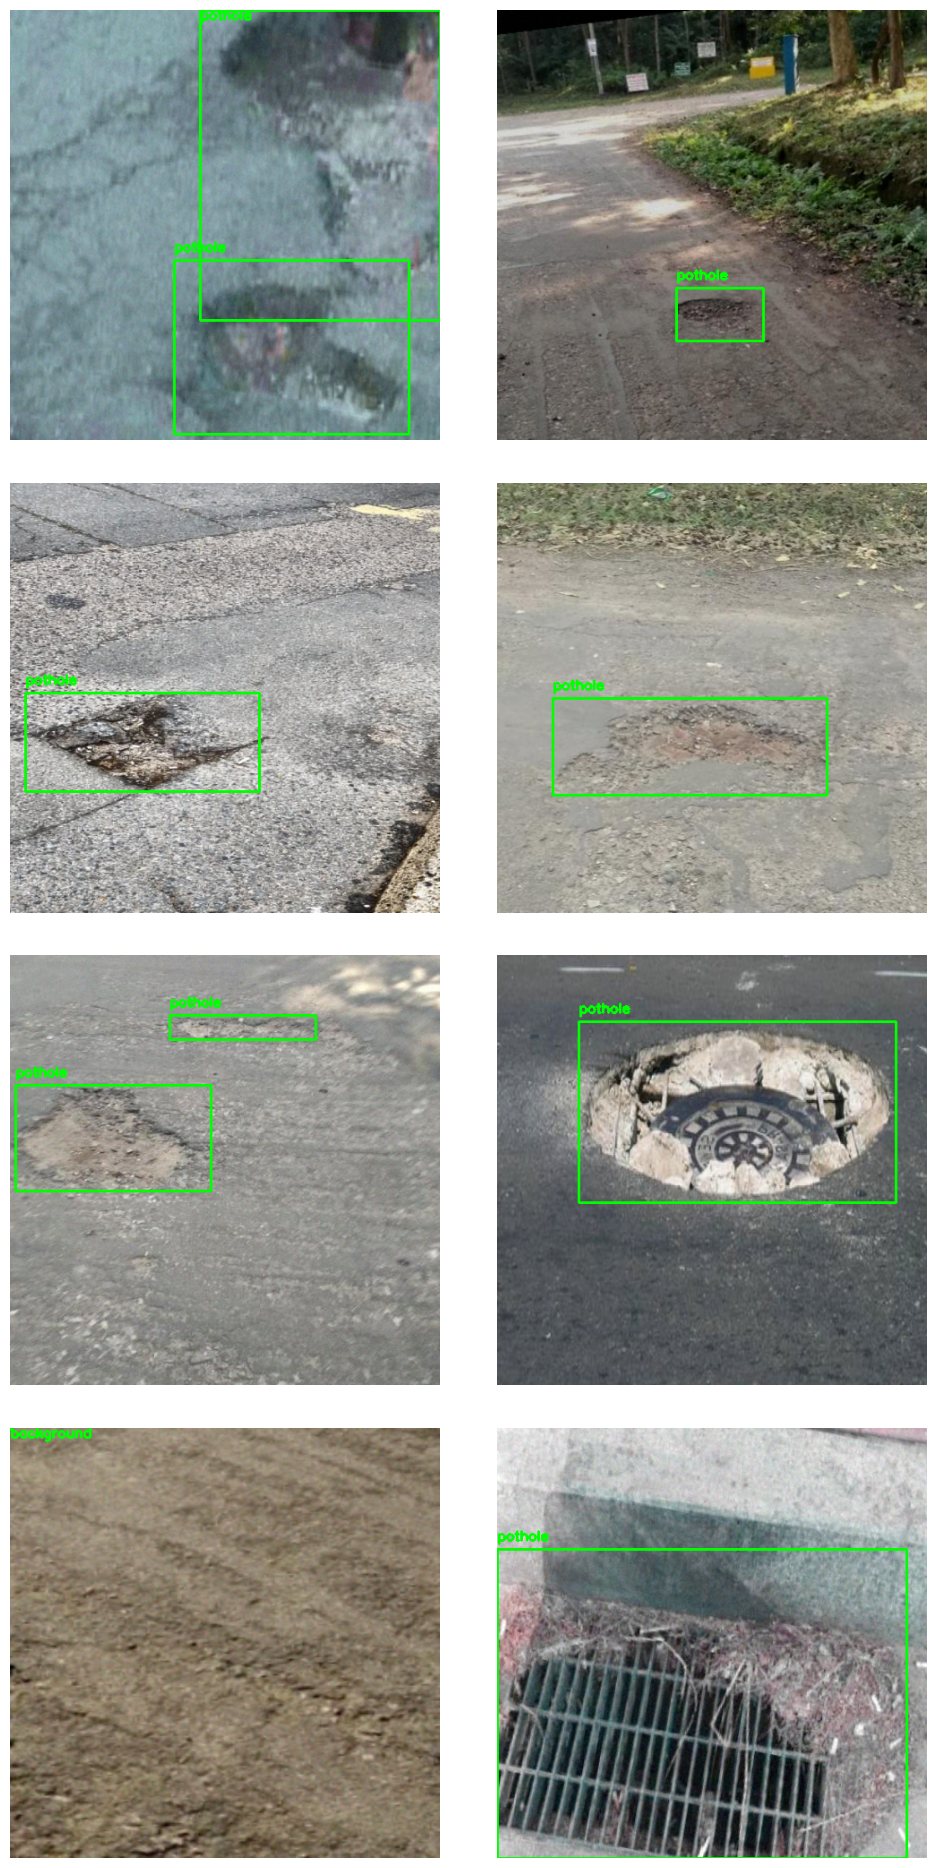

In [17]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

# DataLoader

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)
test_dl=DataLoader(test_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

# Model

In [20]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 146MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [21]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)

lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

# Training

In [23]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [24]:
from tqdm import tqdm

loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0

    current_lr=get_lr(optimizer)

    #During training, the model expects both the input tensors, as well as a targets
    model.train()
    for imgs,targets in tqdm(train_dl):
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()


    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")


    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print("Epoch {}/{}, Training Loss : {}, Validation Loss : {}". format(epoch+1, epochs, training_loss/train_len, validation_loss/val_len))

torch.save(best_weights,model_weights_file)

100%|██████████| 301/301 [01:59<00:00,  2.52it/s]


Updating Best Model weights
Epoch 1/40, Training Loss : 0.8041123565321995, Validation Loss : 0.6932604001011959


100%|██████████| 301/301 [01:55<00:00,  2.60it/s]


Updating Best Model weights
Epoch 2/40, Training Loss : 0.6841215320677494, Validation Loss : 0.6293645404105963


100%|██████████| 301/301 [01:56<00:00,  2.58it/s]


Updating Best Model weights
Epoch 3/40, Training Loss : 0.6177779649568882, Validation Loss : 0.5592779233012088


100%|██████████| 301/301 [01:55<00:00,  2.61it/s]


Updating Best Model weights
Epoch 4/40, Training Loss : 0.564993023624745, Validation Loss : 0.514458085215369


100%|██████████| 301/301 [01:57<00:00,  2.55it/s]


Updating Best Model weights
Epoch 5/40, Training Loss : 0.5194259265373493, Validation Loss : 0.48874129354953766


100%|██████████| 301/301 [01:56<00:00,  2.59it/s]


Updating Best Model weights
Epoch 6/40, Training Loss : 0.4964889774790036, Validation Loss : 0.4577212167340656


100%|██████████| 301/301 [01:54<00:00,  2.63it/s]


Updating Best Model weights
Epoch 7/40, Training Loss : 0.470818032453701, Validation Loss : 0.443760659805564


100%|██████████| 301/301 [01:53<00:00,  2.64it/s]


Updating Best Model weights
Epoch 8/40, Training Loss : 0.46351052113078567, Validation Loss : 0.43543400840703833


100%|██████████| 301/301 [01:59<00:00,  2.53it/s]


Updating Best Model weights
Epoch 9/40, Training Loss : 0.4594359158181926, Validation Loss : 0.4219191063975179


100%|██████████| 301/301 [01:52<00:00,  2.67it/s]


Updating Best Model weights
Epoch 10/40, Training Loss : 0.43977992317713194, Validation Loss : 0.41649141353230146


100%|██████████| 301/301 [01:56<00:00,  2.59it/s]


Updating Best Model weights
Epoch 11/40, Training Loss : 0.4319930414367029, Validation Loss : 0.41333587744901346


100%|██████████| 301/301 [01:51<00:00,  2.69it/s]


Updating Best Model weights
Epoch 12/40, Training Loss : 0.42259229135850085, Validation Loss : 0.40308019206967466


100%|██████████| 301/301 [01:53<00:00,  2.65it/s]


Updating Best Model weights
Epoch 13/40, Training Loss : 0.42252236820129024, Validation Loss : 0.4013692594544832


100%|██████████| 301/301 [01:56<00:00,  2.58it/s]


Updating Best Model weights
Epoch 14/40, Training Loss : 0.42015191336910307, Validation Loss : 0.3978026935527491


100%|██████████| 301/301 [01:53<00:00,  2.65it/s]


Updating Best Model weights
Epoch 15/40, Training Loss : 0.4010444995918163, Validation Loss : 0.3913424261087595


100%|██████████| 301/301 [01:51<00:00,  2.70it/s]


Updating Best Model weights
Epoch 16/40, Training Loss : 0.4019448034090772, Validation Loss : 0.38948708807313165


100%|██████████| 301/301 [01:53<00:00,  2.64it/s]


Epoch 17/40, Training Loss : 0.3984031518762618, Validation Loss : 0.3895710207695185


100%|██████████| 301/301 [01:51<00:00,  2.69it/s]


Updating Best Model weights
Epoch 18/40, Training Loss : 0.39459092378319177, Validation Loss : 0.38432727476885153


100%|██████████| 301/301 [01:56<00:00,  2.58it/s]


Updating Best Model weights
Epoch 19/40, Training Loss : 0.38890402486426334, Validation Loss : 0.37985391810882924


100%|██████████| 301/301 [01:52<00:00,  2.67it/s]


Updating Best Model weights
Epoch 20/40, Training Loss : 0.393423002936011, Validation Loss : 0.37943853767112246


100%|██████████| 301/301 [01:54<00:00,  2.62it/s]


Updating Best Model weights
Epoch 21/40, Training Loss : 0.3889636051422043, Validation Loss : 0.3745767115507015


100%|██████████| 301/301 [01:53<00:00,  2.66it/s]


Updating Best Model weights
Epoch 22/40, Training Loss : 0.38130385112009657, Validation Loss : 0.3734631638887317


100%|██████████| 301/301 [01:54<00:00,  2.63it/s]


Updating Best Model weights
Epoch 23/40, Training Loss : 0.37728394434865103, Validation Loss : 0.3705688080815382


100%|██████████| 301/301 [01:55<00:00,  2.62it/s]


Updating Best Model weights
Epoch 24/40, Training Loss : 0.378956093697019, Validation Loss : 0.36809795401817147


100%|██████████| 301/301 [01:55<00:00,  2.62it/s]


Updating Best Model weights
Epoch 25/40, Training Loss : 0.37434175785121754, Validation Loss : 0.3668952546147413


100%|██████████| 301/301 [01:52<00:00,  2.67it/s]


Epoch 26/40, Training Loss : 0.3646473099098792, Validation Loss : 0.36693265982145484


100%|██████████| 301/301 [01:57<00:00,  2.56it/s]


Epoch 27/40, Training Loss : 0.3736764842858689, Validation Loss : 0.37227676808834076


100%|██████████| 301/301 [01:53<00:00,  2.65it/s]


Updating Best Model weights
Epoch 28/40, Training Loss : 0.3679906026327516, Validation Loss : 0.36535556804995206


100%|██████████| 301/301 [01:54<00:00,  2.62it/s]


Updating Best Model weights
Epoch 29/40, Training Loss : 0.3652765246709452, Validation Loss : 0.3619432797612146


100%|██████████| 301/301 [01:51<00:00,  2.69it/s]


Epoch 30/40, Training Loss : 0.3574978000750223, Validation Loss : 0.3642341650502626


100%|██████████| 301/301 [01:52<00:00,  2.67it/s]


Updating Best Model weights
Epoch 31/40, Training Loss : 0.35599278452785665, Validation Loss : 0.35937503690636435


100%|██████████| 301/301 [01:56<00:00,  2.58it/s]


Updating Best Model weights
Epoch 32/40, Training Loss : 0.35113924402491303, Validation Loss : 0.3567871142958486


100%|██████████| 301/301 [01:55<00:00,  2.61it/s]


Updating Best Model weights
Epoch 33/40, Training Loss : 0.3531282697419284, Validation Loss : 0.35573943496443505


100%|██████████| 301/301 [01:57<00:00,  2.55it/s]


Updating Best Model weights
Epoch 34/40, Training Loss : 0.3582647070133889, Validation Loss : 0.3534400322756102


100%|██████████| 301/301 [01:52<00:00,  2.69it/s]


Updating Best Model weights
Epoch 35/40, Training Loss : 0.34570899260306587, Validation Loss : 0.3520239425259967


100%|██████████| 301/301 [01:55<00:00,  2.60it/s]


Epoch 36/40, Training Loss : 0.35188863081312, Validation Loss : 0.3538956162194873


100%|██████████| 301/301 [01:54<00:00,  2.64it/s]


Epoch 37/40, Training Loss : 0.35385439769331234, Validation Loss : 0.3567350628071053


100%|██████████| 301/301 [01:56<00:00,  2.57it/s]


Epoch 38/40, Training Loss : 0.34818423284650296, Validation Loss : 0.3522280529141426


100%|██████████| 301/301 [01:54<00:00,  2.62it/s]


Updating Best Model weights
Epoch 39/40, Training Loss : 0.3407926185526291, Validation Loss : 0.3490587862771611


100%|██████████| 301/301 [01:55<00:00,  2.60it/s]


Updating Best Model weights
Epoch 40/40, Training Loss : 0.33666459554253053, Validation Loss : 0.3466221931022267


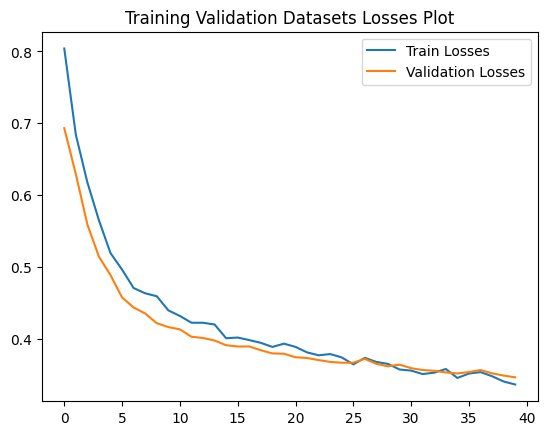

In [25]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");

# Evaluation

In [26]:
model_weights_pth="/content/model.pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:04<00:00, 112MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [27]:
def preprocess_bbox(prediction):
    processed_bbox={}

    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)

    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]

    return processed_bbox

In [28]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in test_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)

        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        metric.update(results,targets)

results=metric.compute()

In [29]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.4240
Mean Average Precision @ 0.5          : 0.6831
Mean Average Precision @ 0.75         : 0.4820


# Inference

IndexError: ignored

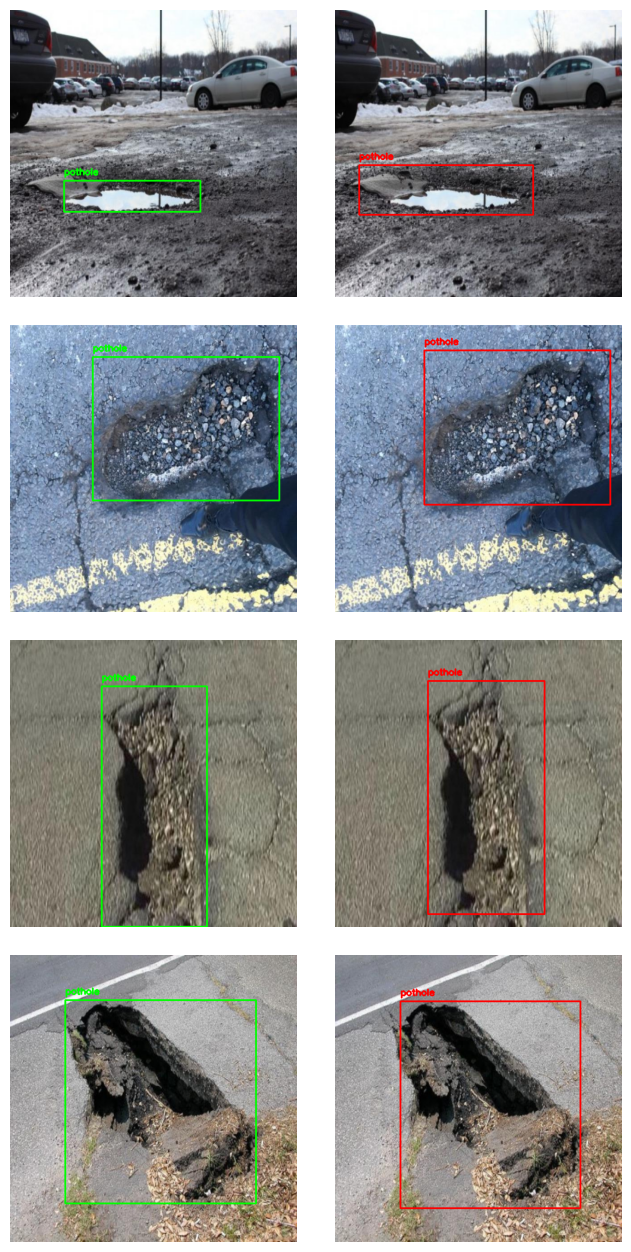

In [30]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(test_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]

    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");

    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");

# Video Inference

In [31]:
import time

video_path="video.mp4"
video_out_path="output_video.mp4"

cap=cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')

# define codec and create VideoWriter object
out=cv2.VideoWriter(video_out_path,
                    cv2.VideoWriter_fourcc(*'XVID'), 30,
                    (480,480))

model=model.eval()

frame_count = 0
total_fps = 0  # Deklarasi variabel fps

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame=cap.read()
    if ret==True:
        with torch.no_grad():
            # get predictions for the current frame
            frame=cv2.resize(frame,(480,480))
            frame=frame/255
            frame=np.transpose(frame,(2,0,1))
            frame=torch.as_tensor(frame,dtype=torch.float32)
            frame=frame.to(device)
            start_time = time.time()  # Waktu awal
            output=model([frame])
            end_time = time.time()

            # Get the current fps.
            fps = 1 / (end_time - start_time)
            # Total FPS till current frame.
            total_fps += fps
            frame_count += 1

            predict=preprocess_bbox(output[0])
            output_img=show_bbox(frame,predict)
            output_img=(output_img*255).astype(np.uint8)
            # Tambahkan informasi FPS ke dalam frame
            cv2.putText(output_img, f"{fps:.0f} FPS",
                    (15, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0),
                    2, lineType=cv2.LINE_AA)

            out.write(output_img)
    else:
        break

# release VideoCapture()
out.release()
cap.release()